<a href="https://colab.research.google.com/github/amansandhu408/deep-learning/blob/main/radar_fmcw_uwb_97_85_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

2026-02-21 20:06:28.945919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771704389.265633      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771704389.358443      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771704390.148735      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771704390.148778      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771704390.148781      55 computation_placer.cc:177] computation placer alr

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 40
TUNER_EPOCHS = 5
NUM_CLASSES = 6

DATA_PATH = "/kaggle/input/datasets/amansandhu408/csio-radar-imagedataset/csio_spectrograms"

LABEL MAPPING

In [ ]:
def map_label(activity):
    activity = activity.lower()
    if activity == "standing": return 0
    elif activity == "walking": return 1
    elif activity == "sitting": return 2
    elif activity == "kneeling": return 3
    elif activity in ["bending_left","bending_right","bending_front_back"]: return 4
    elif activity in ["falling_forward","falling_backward","falling_sideways"]: return 5

In [ ]:
from glob import glob

def build_dataframe(base_path):
    records = []
    for radar in os.listdir(base_path):
        for room in os.listdir(os.path.join(base_path, radar)):
            for sensor in os.listdir(os.path.join(base_path, radar, room)):
                for activity in os.listdir(os.path.join(base_path, radar, room, sensor)):
                    path = os.path.join(base_path, radar, room, sensor, activity)
                    for img in glob(path + "/*.*"):
                        records.append({
                            "path": img,
                            "radar": radar.lower(),
                            "sensor": sensor.lower(),
                            "room": room.lower(),
                            "activity": activity.lower(),
                            "label": map_label(activity)
                        })
    df = pd.DataFrame(records)
    print("Total images:", len(df))
    return df

df = build_dataframe(DATA_PATH)

Total images: 18727


UPSAMPLING

In [ ]:
max_count = df.label.value_counts().max()

dfs = []
for label in df.label.unique():
    temp = df[df.label == label]
    dfs.append(temp.sample(max_count, replace=True, random_state=42))

df_balanced = pd.concat(dfs).reset_index(drop=True)

In [ ]:
# Class distribution after upsampling
class_counts = df_balanced.label.value_counts().sort_index()

print("🔹 Class-wise sample count AFTER upsampling:\n")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples")

print("\n🔹 Total samples after upsampling:", len(df_balanced))

🔹 Class-wise sample count AFTER upsampling:

Class 0: 6260 samples
Class 1: 6260 samples
Class 2: 6260 samples
Class 3: 6260 samples
Class 4: 6260 samples
Class 5: 6260 samples

🔹 Total samples after upsampling: 37560


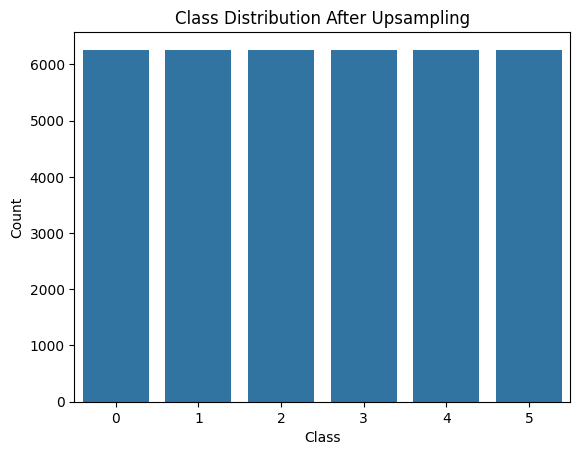

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_balanced.label)
plt.title("Class Distribution After Upsampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

TRAIN - TEST SPLIT (80-20)

In [ ]:
train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced.label,
    random_state=42
)

PARSING

In [ ]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32)

    return img, label


def augment(img, label):
    img = tf.cast(img, tf.float32)
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_brightness(img, 0.1)
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_contrast(img, 0.8, 1.2)
    if tf.random.uniform([]) < 0.5:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
        img = img + noise

    return img, label


def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, label

In [ ]:
def make_dataset(df, training=True):
    ds = tf.data.Dataset.from_tensor_slices((df.path.values, df.label.values))
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, True)
val_ds   = make_dataset(val_df, False)

I0000 00:00:1771704427.861119      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


CLASS WEIGHTS

In [ ]:
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(train_df.label),
    y=train_df.label
)
class_weights = dict(enumerate(class_weights))

In [ ]:
def attention_fusion(f1, f2):
    a1 = layers.Dense(1)(f1)
    a2 = layers.Dense(1)(f2)

    concat = layers.Concatenate()([a1, a2])
    weights = layers.Softmax()(concat)

    w1 = layers.Lambda(lambda x: x[:,0:1])(weights)
    w2 = layers.Lambda(lambda x: x[:,1:2])(weights)

    f1 = layers.Multiply()([f1, w1])
    f2 = layers.Multiply()([f2, w2])

    return layers.Add()([f1, f2])

MODEL

In [ ]:
def build_model():

    lr = 1e-4
    wd = 1e-5
    dropout = 0.3

    dense1 = 512
    dense2 = 256
    dense3 = 64

    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    base = Xception(weights="imagenet", include_top=False, pooling="avg")
    base.trainable = False

    f = base(inp)

    x = layers.BatchNormalization()(f)

    # 🔹 Dense Layer 1
    x = layers.Dense(dense1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # 🔹 Dense Layer 2
    x = layers.Dense(dense2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # 🔹 Dense Layer 3
    x = layers.Dense(dense3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    embedding = layers.Dense(128, activation="relu", name="embedding")(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(embedding)

    model = keras.Model(inp, out)

    opt = keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
model = build_model()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,078,958 (84.22 MB)

 Trainable params: 1,211,718 (4.62 MB)

 Non-trainable params: 20,867,240 (79.60 MB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )

In [ ]:
import time
start_time= time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop]
)

end_time = time.time()

print(f"\nTraining Time : {end_time - start_time} sec")

Epoch 1/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.8694 - loss: 0.3648 - val_accuracy: 0.9111 - val_loss: 0.2632
Epoch 2/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.8791 - loss: 0.3438 - val_accuracy: 0.9131 - val_loss: 0.2550
Epoch 3/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 84s 87ms/step - accuracy: 0.8813 - loss: 0.3326 - val_accuracy: 0.9179 - val_loss: 0.2437
Epoch 4/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.8928 - loss: 0.3045 - val_accuracy: 0.9216 - val_loss: 0.2302
Epoch 5/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 84s 87ms/step - accuracy: 0.8961 - loss: 0.2899 - val_accuracy: 0.9282 - val_loss: 0.2261
Epoch 6/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 142s 87ms/step - accuracy: 0.8993 - loss: 0.2811 - val_accuracy: 0.9349 - val_loss: 0.2046
Epoch 7/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.9070 - loss: 0.2594 - val_accuracy: 0.9332 - val_loss: 0.2054
Epoch 8/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.9115 - loss: 0.2519 -

TEST ACCURACY (Before Fine-Tuning) : 95.98

TEST ACCURACY (After Fine-Tuning)  : 97.85

In [ ]:
for layer in model.layers[1].layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.AdamW(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/40


2026-02-21 21:16:52.173534: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 21:16:52.361069: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 21:16:53.275667: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 21:16:53.475252: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 21:16:53.893906: E external/local_xla/xla/stream_

939/939 ━━━━━━━━━━━━━━━━━━━━ 143s 126ms/step - accuracy: 0.6105 - loss: 1.7037 - val_accuracy: 0.8285 - val_loss: 0.5619
Epoch 2/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 118ms/step - accuracy: 0.7866 - loss: 0.6789 - val_accuracy: 0.8931 - val_loss: 0.3320
Epoch 3/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 117ms/step - accuracy: 0.8505 - loss: 0.4435 - val_accuracy: 0.9228 - val_loss: 0.2501
Epoch 4/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 118ms/step - accuracy: 0.8980 - loss: 0.3006 - val_accuracy: 0.9444 - val_loss: 0.1895
Epoch 5/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 118ms/step - accuracy: 0.9197 - loss: 0.2375 - val_accuracy: 0.9530 - val_loss: 0.1597
Epoch 6/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 118ms/step - accuracy: 0.9368 - loss: 0.1886 - val_accuracy: 0.9578 - val_loss: 0.1467
Epoch 7/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 117ms/step - accuracy: 0.9460 - loss: 0.1544 - val_accuracy: 0.9627 - val_loss: 0.1261
Epoch 8/40
939/939 ━━━━━━━━━━━━━━━━━━━━ 112s 117ms/step - accuracy: 0.9629 - loss: 0.11

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,383,100 (161.68 MB)

 Trainable params: 10,152,070 (38.73 MB)

 Non-trainable params: 11,926,888 (45.50 MB)

 Optimizer params: 20,304,142 (77.45 MB)

In [ ]:
from sklearn.metrics import accuracy_score

start_time = time.time()

probs = model.predict(val_ds)
preds = np.argmax(probs, axis=1)

end_time = time.time()

true = val_df.label.values[:len(preds)]
val_acc = accuracy_score(true, preds)

total_time = end_time - start_time
time_per_sample = total_time / len(preds)

print("🔹 Validation Accuracy:", val_acc)
print("🔹 Total Inference Time (sec):", total_time)
print("🔹 Time per Sample (sec):", time_per_sample)

235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step
🔹 Validation Accuracy: 0.9785676251331203
🔹 Total Inference Time (sec): 24.503764152526855
🔹 Time per Sample (sec): 0.0032619494345749274


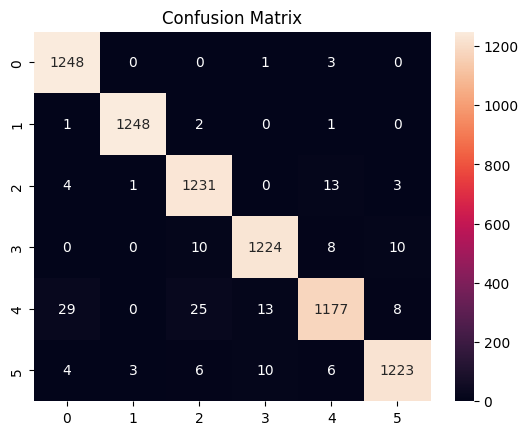

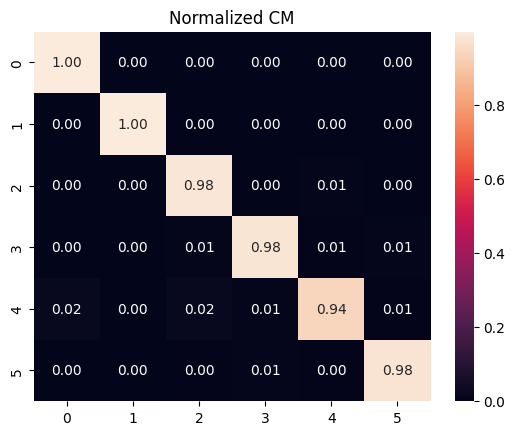

In [ ]:
cm = confusion_matrix(true,preds)

sns.heatmap(cm,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.show()

cmn = cm/cm.sum(axis=1,keepdims=True)

sns.heatmap(cmn,annot=True,fmt=".2f")
plt.title("Normalized CM")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# 🔹 Overall metrics
precision = precision_score(true, preds, average='weighted')
recall    = recall_score(true, preds, average='weighted')
f1        = f1_score(true, preds, average='weighted')

print("🔹 Precision (weighted):", precision)
print("🔹 Recall (weighted):   ", recall)
print("🔹 F1 Score (weighted): ", f1)

🔹 Precision (weighted): 0.9786216850931434
🔹 Recall (weighted):    0.9785676251331203
🔹 F1 Score (weighted):  0.9784997776486449


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

class_names = ["Standing","Walking","Sitting","Kneeling","Bending","Falling"]

# Convert to dictionary
report_dict = classification_report(
    true,
    preds,
    target_names=class_names,
    output_dict=True
)

# Convert to DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# Keep only class rows (remove avg rows for now)
df_classes = df_report.iloc[:len(class_names)]

# Round for clean display
df_classes = df_classes.round(4)

print("🔹 Per-Class Metrics Table:\n")
display(df_classes)

🔹 Per-Class Metrics Table:



,precision,recall,f1-score,support
Standing,0.9705,0.9968,0.9835,1252.0
Walking,0.9968,0.9968,0.9968,1252.0
Sitting,0.9662,0.9832,0.9747,1252.0
Kneeling,0.9808,0.9776,0.9792,1252.0
Bending,0.9743,0.9401,0.9569,1252.0
Falling,0.9831,0.9768,0.9800,1252.0


In [ ]:
print("\n🔹 Full Report (including averages):\n")
display(df_report.round(4))


🔹 Full Report (including averages):



,precision,recall,f1-score,support
Standing,0.9705,0.9968,0.9835,1252.0000
Walking,0.9968,0.9968,0.9968,1252.0000
Sitting,0.9662,0.9832,0.9747,1252.0000
Kneeling,0.9808,0.9776,0.9792,1252.0000
Bending,0.9743,0.9401,0.9569,1252.0000
Falling,0.9831,0.9768,0.9800,1252.0000
accuracy,0.9786,0.9786,0.9786,0.9786
macro avg,0.9786,0.9786,0.9785,7512.0000
weighted avg,0.9786,0.9786,0.9785,7512.0000


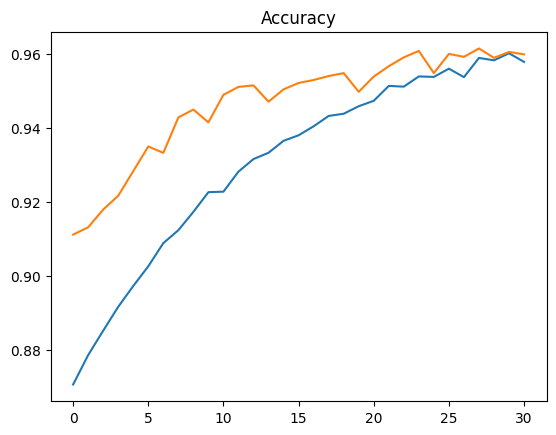

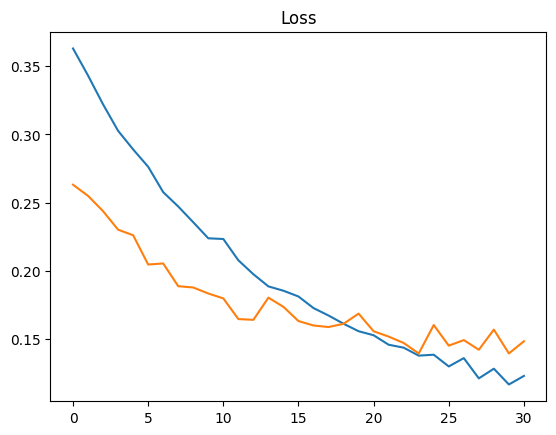

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.show()

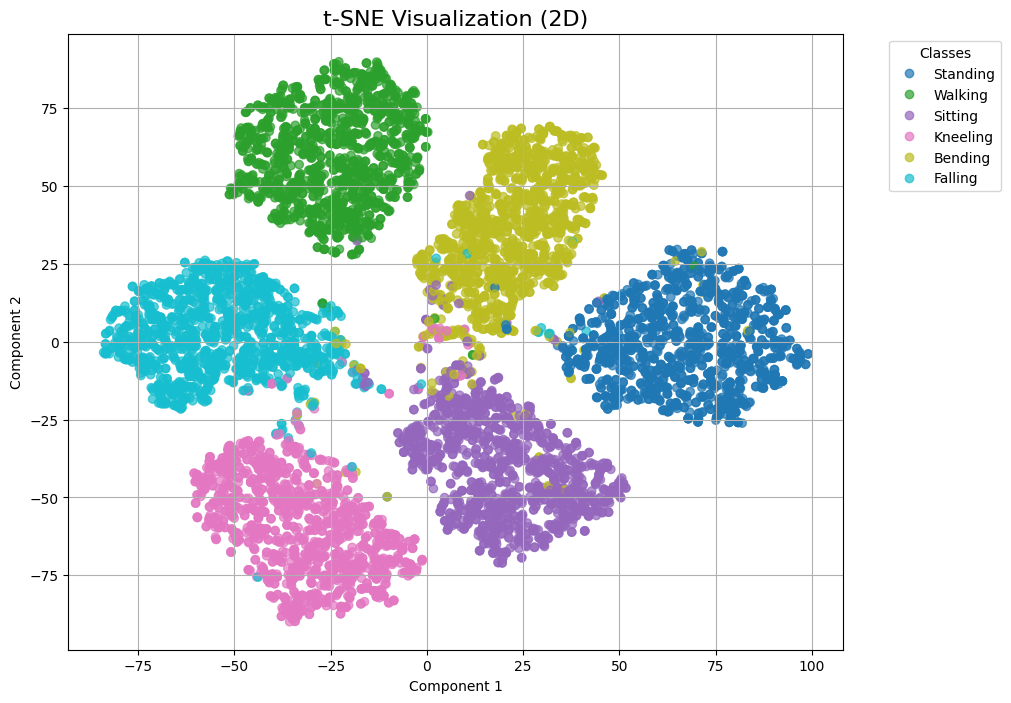

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class names (VERY IMPORTANT for readability)
class_names = ["Standing","Walking","Sitting","Kneeling","Bending","Falling"]

plt.figure(figsize=(10,8))

scatter = plt.scatter(
    emb[:,0],
    emb[:,1],
    c=true,
    cmap="tab10",
    alpha=0.7
)

# Legend
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("t-SNE Visualization (2D)", fontsize=16)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne_3d = TSNE(n_components=3, random_state=42)
emb_3d = tsne_3d.fit_transform(features)



import plotly.express as px
import pandas as pd

df_tsne = pd.DataFrame({
    "x": emb_3d[:,0],
    "y": emb_3d[:,1],
    "z": emb_3d[:,2],
    "label": true
})

df_tsne["label_name"] = df_tsne["label"].map({
    0:"Standing", 1:"Walking", 2:"Sitting",
    3:"Kneeling", 4:"Bending", 5:"Falling"
})

fig = px.scatter_3d(
    df_tsne,
    x="x", y="y", z="z",
    color="label_name",
    title="3D t-SNE Visualization",
    opacity=0.7
)

fig.show()

In [ ]:
fig.write_html("/kaggle/working/tsne_3d.html")